<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/auto_circuits_humongous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Quantum Circuits
#### dehls - pinballsurgeon@gmail.com

###Installs

In [56]:
# tensorflow quantum
!pip install --quiet tensorflow_quantum

# bloch sphere
!pip install --quiet qutip

###Imports

In [119]:
### standard dan-dards
import cirq
import sympy
import tensorflow
import numpy
import gc
import random

# metric plotting
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pyplot import figure

# tf quantum
import tensorflow_quantum

# circuit/operations visualizers
import qutip
from cirq.contrib.svg import SVGCircuit

###Experiment configuration and hyper-parameters

In [ ]:
### Define your quantum machine learning experiment, the values here are optimized for best 'Colab free-tier' experience

# qubit grid sizes - how big do you want your circuit's grid size range to be
experiment_grid_sizes = [2, 3, 4]

# experiment count - how many arrangements of gates
experiment_runs = 5

# gate combination range - how many, or few, combination of gates per experiemental run
min_gate_cobination = 1
max_gate_cobination = 4

# cirq gates to hyperparameterize
gate_mix = [cirq.CZ
           ,cirq.CNOT
           ,cirq.XX
           ,cirq.ISWAP
           ,cirq.ZZ
           ,cirq.SWAP
           ,cirq.YY]


# learning parameters
EPOCHS = 2
BATCH_SIZE = 25
ADAM_OPTIMIZER_LEARNING_RATE = 0.11

# for MINST binary classifier, pick a single digit for TARGET and a single digit for JUNK
target_mnist_digit = 3
junk_mnist_digit = 4



###Helper Functions

In [59]:
### Initialize circuit - given a data and out qubit structure, build dynamic circuit
class circuit_struct():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [129]:
### Populate circuit with gates - given a combination of qubit grid size and gate population, build 
def create_quantum_model(gridSize, hyperGates):

    # cirq
    data_qubits = cirq.GridQubit.rect(gridSize, gridSize)
    readout = cirq.GridQubit(-1, -1)         
    circuit = cirq.Circuit()
    
    # prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    # create qubit
    builder = circuit_struct(
        data_qubits = data_qubits,
        readout=readout)

    # buid layers
    for gate in hyperGates:

      # add specified gate and name
      builder.add_layer(circuit, gate, str(gate))
   
    # prepare the readout qubit
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [61]:
### image pixels to qubit
def convert_to_circuit(image):

    # flatten array
    values = numpy.ndarray.flatten(image)
    
    # establish 4x4 circuit
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()

    # 
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [62]:
### this example is for binary classification, so only keep one MNIST class/digit as target, and then one other as NON-TARGET/JUNK
def binary_filter(x, y):

    # identify rows that will be kept
    keep = (y == target_mnist_digit) | (y == junk_mnist_digit)
    
    # remove excess
    x, y = x[keep], y[keep]

    # establish target 1/0
    y = y == target_mnist_digit
 
    return x,y

In [93]:
### reveal experiment results per run
def experiment_reveal(log, run):

  fig, (ax1, ax2) = pyplot.subplots(2)
  pyplot.title('MSE Loss and Accuracy of %s gated Parametrized Quantum Circuit' % (log[run]['gates']), fontdict = {'fontsize' :16})

  ax1.plot(log[run]['history'].history['loss'])
  ax1.plot(log[run]['history'].history['val_loss'])
  ax1.set_ylabel('MSE')

  ax2.plot(log[run]['history'].history['accuracy'])
  ax2.plot(log[run]['history'].history['val_accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  
  fig = pyplot.gcf()
  fig.set_size_inches(12.5, 7.5)

  return log[run]['circuit']


###Build experiment circuits and gates

In [130]:
### build experiment

experiment_design = []

# given experiement design parameters, build experiment(s)
for run in range(1, experiment_runs+1):

  # gate combination
  gate_combination = random.choices(gate_mix, k=random.randrange(min_gate_cobination, max_gate_cobination))

  # print random experiment gate participants
  print('Experiment %d Gates:' % run); print(gate_combination); print('')

  # build experiment
  experiment_design.append(gate_combination)


Experiment 1 Gates:
[cirq.CZ, cirq.SWAP, cirq.XX]

Experiment 2 Gates:
[cirq.CNOT, cirq.ZZ]

Experiment 3 Gates:
[cirq.ZZ, cirq.CZ]

Experiment 4 Gates:
[cirq.SWAP, cirq.ZZ]

Experiment 5 Gates:
[cirq.ISWAP]



###Load Dataset

In [63]:
### establish dataset, here the MNIST numerical yada-yada

# 1. import mnist digits
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

# 2. rescale images to [0 - 1]
x_train, x_test = x_train[..., numpy.newaxis]/255.0, x_test[..., numpy.newaxis]/255.0

# 3. quantum experiment is binary classification, so only keep two classes/digit examples
x_train, y_train = binary_filter(x_train, y_train)
x_test, y_test = binary_filter(x_test, y_test)

# 4. resize image
x_train_small = tensorflow.image.resize(x_train, (4,4)).numpy()
x_test_small = tensorflow.image.resize(x_test, (4,4)).numpy()

# 5. convert circuit pixels/cells into individual qubits
x_train_circ = [convert_to_circuit(x) for x in x_train_small]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

# 6. convert to qubit imagery into tensors
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)

###Tensorflow quantum network

In [65]:
### tensorflow callbacks, here specifically garbage collection as to reduce memory load below colab free tier
class mem_release(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [131]:
### tensorflow quantum experimental gate combinatorial iterator 

# keep track of experiment conditions and results
experiment_count = 0
experiment_log = {}


for gates in experiment_design:
  for gridSize_int in experiment_grid_sizes:


    # initialize quantum circuit
    model_circuit, model_readout = create_quantum_model(gridSize_int, gates)


    # build tf model
    model = tensorflow.keras.Sequential([
        
        # input data circuit as tf.string
        tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string),

        # parameterized quantum circuit
        tensorflow_quantum.layers.PQC(model_circuit, model_readout),])


    # compile model and determine loss / optimizer approach, for this introductory we'll focus on memory
    model.compile(

        # loss, mean square error
        loss=tensorflow.keras.losses.mse,

        # optimizer, Adam with specifiable learning rate
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=ADAM_OPTIMIZER_LEARNING_RATE),
      
        # metrics, accuracy
        metrics=[tensorflow.keras.metrics.Accuracy()]
      )
    
    # display model parameters
    print(''); print(''.join(str(gates))); print(model.summary())

    # train model for experiment, define training and validation populations, callbacks ect.
    experiment_history = model.fit(
        x_train_tfcirc,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[mem_release()],
        validation_data=(x_test_tfcirc, y_test)
        )

    # after training, evaluate final model representation against test set
    experiment_results = model.evaluate(x_test_tfcirc, y_test)

    # record experiment
    experiment_count += 1
    experiment_log[experiment_count] = {'circuit' : model_circuit       
                                       ,'gates'   : gates
                                       ,'history' : experiment_history
                                       ,'results' : experiment_results }
    


[cirq.CZ, cirq.SWAP, cirq.XX]
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_22 (PQC)                (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
479/479 [==============================] - 22s 44ms/step - loss: 0.3534 - accuracy: 0.0622 - val_loss: 0.3447 - val_accuracy: 0.0050
Epoch 2/2
63/63 [==============================] - 2s 31ms/step - loss: 0.3131 - accuracy: 0.1727

[cirq.CZ, cirq.SWAP, cirq.XX]
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_23 (PQC)                (None, 1)                 27        
                                                        

KeyboardInterrupt: ignored

##Circuit #1 - design and results

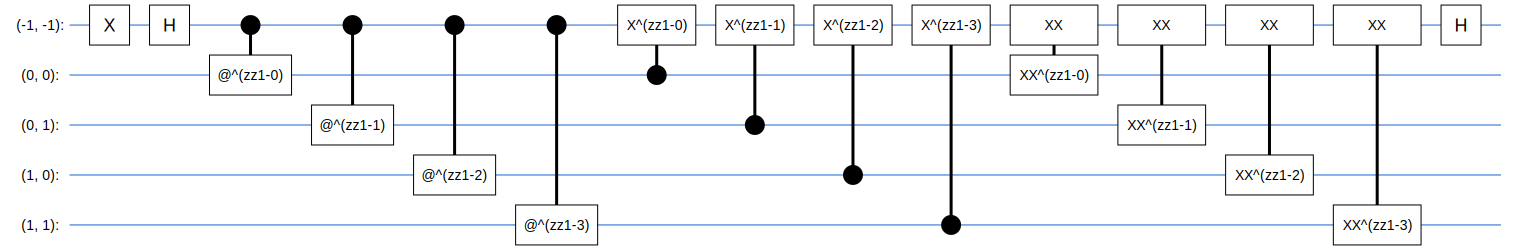

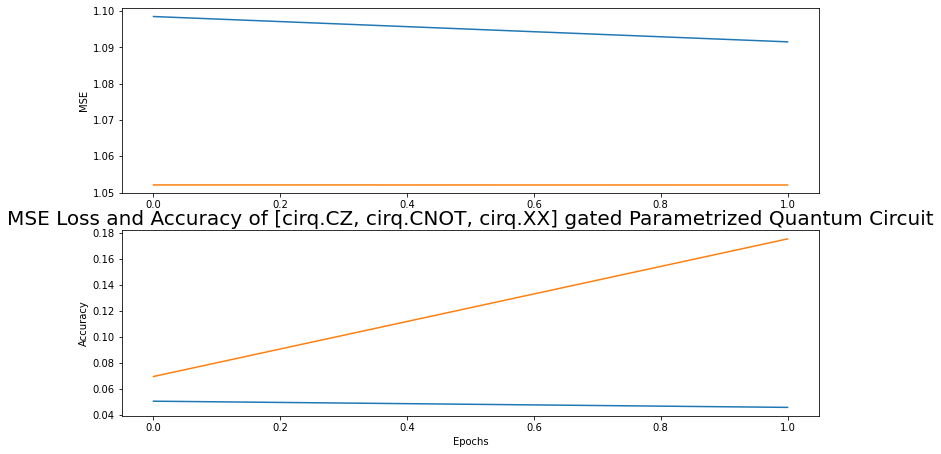

In [108]:
SVGCircuit(experiment_reveal(experiment_log, 1))

##Circuit #2 - design and results

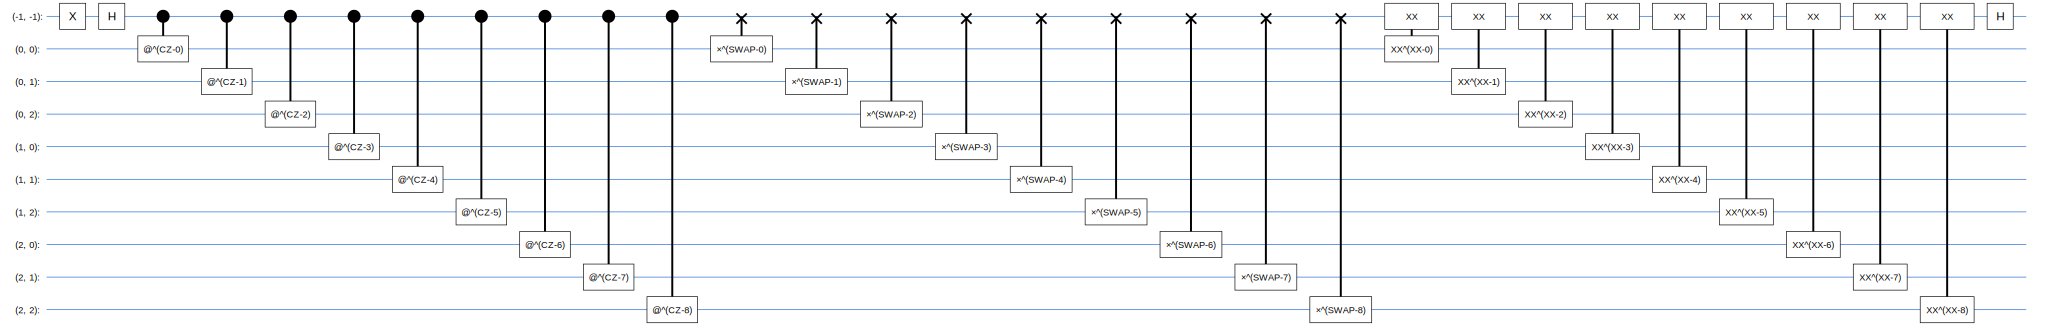

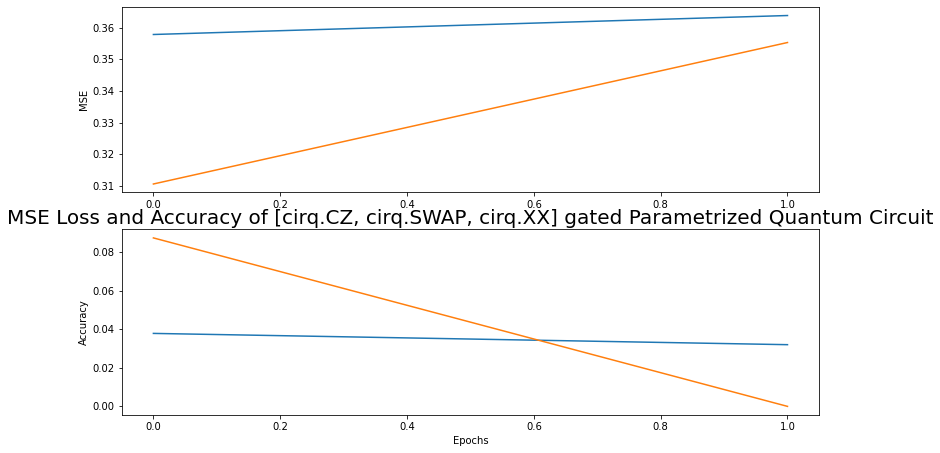

In [133]:
SVGCircuit(experiment_reveal(experiment_log, 2))

##Circuit #3 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 3))

##Circuit #4 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 4))

##Circuit #5 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 5))

##Circuit #6 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 6))

##Circuit #7 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 7))

##Circuit #8 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 8))

##Circuit #9 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 9))

##Circuit #10 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 10))

##Circuit #11 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 11))

##Circuit #12 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 12))

##Circuit #13 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 13))

##Circuit #14 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 14))

##Circuit #15 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 14))